# Phishing site identifier

## 1. Objective

The goal is to find out if it's possible to reliably predict if a website is a phishing site based on easily obtainable information about the site. 

The target variable "Result" indicates whether a website is a phishing site or not.

For this task, decision tree and random forest classifiers are used.

In [98]:
from ucimlrepo import fetch_ucirepo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# fetch dataset 
phishing_websites = fetch_ucirepo(id=327)

df_features = phishing_websites.data.features #X
df_targets = phishing_websites.data.targets #Y

df = pd.DataFrame(df_features, columns=df_features.columns)

## 2. Understanding the data

The dataset consists of: 
* **Targets:** which indicate if the website is a phishin site or not (1 = phishing, -1 = legitimate). 
* **Features:** which are features that characterize phishing websites.


### Features (Variables):

In [99]:
print(phishing_websites.variables)


                          name     role     type demographic description  \
0            having_ip_address  Feature  Integer        None        None   
1                   url_length  Feature  Integer        None        None   
2           shortining_service  Feature  Integer        None        None   
3             having_at_symbol  Feature  Integer        None        None   
4     double_slash_redirecting  Feature  Integer        None        None   
5                prefix_suffix  Feature  Integer        None        None   
6            having_sub_domain  Feature  Integer        None        None   
7               sslfinal_state  Feature  Integer        None        None   
8   domain_registration_length  Feature  Integer        None        None   
9                      favicon  Feature  Integer        None        None   
10                        port  Feature  Integer        None        None   
11                 https_token  Feature  Integer        None        None   
12          

In [100]:
df.head(5)

,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,rightclick,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,1,-1,-1,-1,-1,1,1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,1,-1,-1,0,-1,1,1,1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,1,-1,1,-1,1,0,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,1,-1,-1,1,-1,1,-1,1
4,1,0,-1,1,1,-1,1,1,-1,1,...,1,-1,1,-1,-1,0,-1,1,1,1


**As seen above, most of the variables have 2 possible values: 1 or -1. But some however use 0 to mark a suspicious condition. For example column: "having_sub_domain".**

**It's a middle ground where the website exhibits characteristics that could be interpreted either way.**  

**Summary of the dataset:**

In [101]:
df.describe()

,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,rightclick,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,...,0.913885,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,...,0.405991,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3. Data preparation

Checking that data types are correct:

In [102]:
df.dtypes

having_ip_address             int64
url_length                    int64
shortining_service            int64
having_at_symbol              int64
double_slash_redirecting      int64
prefix_suffix                 int64
having_sub_domain             int64
sslfinal_state                int64
domain_registration_length    int64
favicon                       int64
port                          int64
https_token                   int64
request_url                   int64
url_of_anchor                 int64
links_in_tags                 int64
sfh                           int64
submitting_to_email           int64
abnormal_url                  int64
redirect                      int64
on_mouseover                  int64
rightclick                    int64
popupwindow                   int64
iframe                        int64
age_of_domain                 int64
dnsrecord                     int64
web_traffic                   int64
page_rank                     int64
google_index                

### Splitting the data

Next we need to split the dataset into training and testing sets.

The training set is used to train the model, and the testing set is used to test the model on new unseen data.

In this case we are using 75% of the data for training and the rest for testing the performance.

In [103]:
X = df # features
y = df_targets #results

# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=123)

# checking to make sure the split is correct
print("Training set X:", X_train.shape)
print("Test set X:    ", X_test.shape)
print("Training set y:", y_train.shape)
print("Test set y:    ", y_test.shape)

Training set X: (8291, 30)
Test set X:     (2764, 30)
Training set y: (8291, 1)
Test set y:     (2764, 1)


## 4. Modeling

### 4.1 Decision Tree Model

In [115]:
from sklearn.model_selection import cross_val_score


max_depth = 3
tree = DecisionTreeClassifier(max_depth=max_depth, random_state=123)

# Perform cross-validation on the training data
cv_scores = cross_val_score(tree, X_train, y_train, cv=10)
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Average Cross-Validation Accuracy: {cv_scores.mean():.4f}")

# Fit the model on the entire training set
tree.fit(X_train, y_train)

# Predict on the test set
y_pred = tree.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"Test Set Precision: {precision:.4f}")
print(f"Test Set Recall: {recall:.4f}")


Cross-Validation Accuracy Scores: [0.90240964 0.90711701 0.92882992 0.91676719 0.89264174 0.89987937
 0.91073583 0.92762364 0.90952955 0.91797346]
Average Cross-Validation Accuracy: 0.9114
Test Set Accuracy: 0.9038
Test Set Precision: 0.9038
Test Set Recall: 0.9038


**The resulting decision tree:**

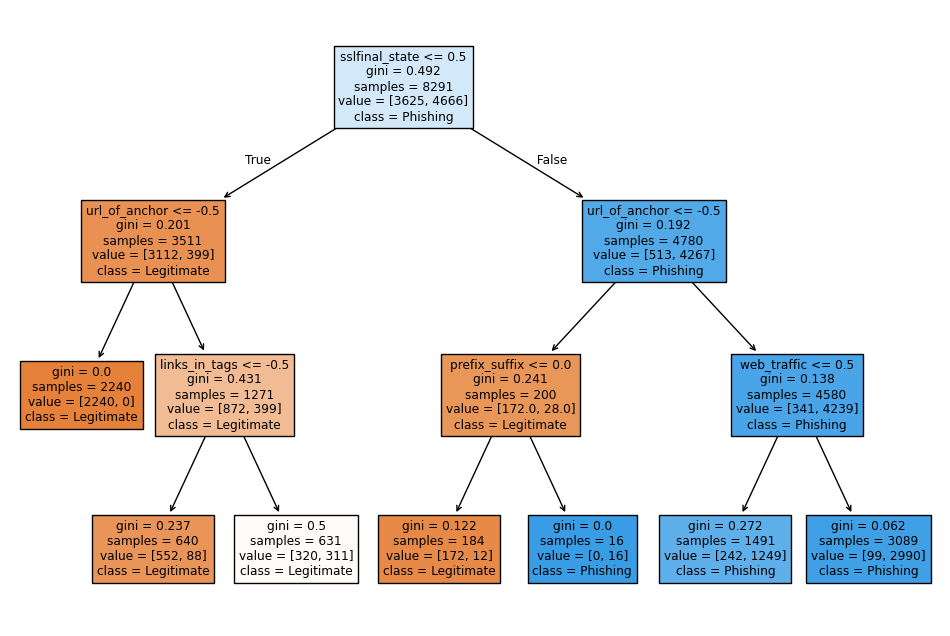

In [116]:
# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['Legitimate', 'Phishing'], filled=True)
plt.show()

### Parameters used:
* max_depth: 3
* random_state: 123

### Model training:
* 10-fold cross validation
* Model was trained on the whole training set after cross-validation

### Performance
With max_depth of 3 the model was able to make the correct choice around 90% of the time and the accuracy stayed the same with both the training data and unseen data.  

### 4.2 Random Forest Model





In [106]:
from sklearn.ensemble import RandomForestClassifier


y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Create a random forest classifier
model = RandomForestClassifier(
    n_estimators=100,        
    bootstrap=True,          
    max_samples=0.7,         
    max_features=0.75,       
    random_state=123         
)

# 10-fold cross-validation on the training data
cv_scores = cross_val_score(model, X_train, y_train, cv=10)
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Average Cross-Validation Accuracy: {cv_scores.mean():.4f}')

# Train the model on the full training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"Test Set Precision: {precision:.4f}")
print(f"Test Set Recall: {recall:.4f}")

Cross-Validation Accuracy Scores: [0.96506024 0.96501809 0.97466828 0.96622437 0.97104946 0.96984318
 0.96260555 0.97828709 0.96501809 0.960193  ]
Average Cross-Validation Accuracy: 0.9678
Test Set Accuracy: 0.9682
Test Set Precision: 0.9684
Test Set Recall: 0.9682


### Parameters used:
* n_estimators(Number of trees in the forest): 100
* max_samples: 0.7 (% of samples in each tree)
* max_features_ 0.75 (% of features considered for splitting)
* random_state: 123

### Model training:
* 10-fold cross-validation
* Model was trained on the whole training set after cross-validation

### Performance:
The model was able to make the correct decision around 97% of the time. 

When comparing cross-validation scores with the scores produced with the unseen test data, we can confirm that the accuracy stayed almost the same with both datasets. This proves that the model wasn't overfitted to the training data.

## 5. Evaluation

### 5.1 Decision tree classifier


Decision Tree - Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.91      0.90      0.90      1273
    Phishing       0.91      0.93      0.92      1491

    accuracy                           0.91      2764
   macro avg       0.91      0.91      0.91      2764
weighted avg       0.91      0.91      0.91      2764



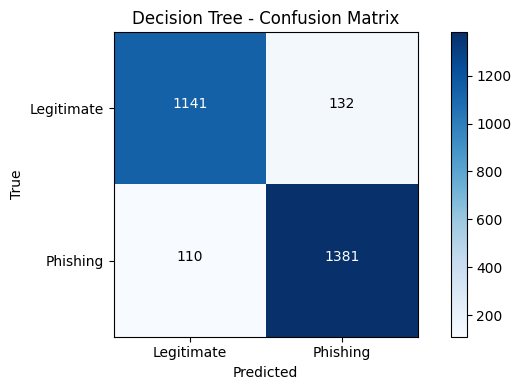

In [107]:
from sklearn.metrics import classification_report


# Predict on the test set
y_pred_tree = tree.predict(X_test)  

# classification report 
print("\nDecision Tree - Classification Report:")
print(classification_report(y_test, y_pred_tree, target_names=['Legitimate', 'Phishing']))

# Compute confusion matrix 
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)

# Plotting the confusion matrix 
plt.figure(figsize=(7, 4))
plt.imshow(conf_matrix_tree, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Decision Tree - Confusion Matrix')
plt.colorbar()
classes = ['Legitimate', 'Phishing']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Adding labels
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, conf_matrix_tree[i, j], horizontalalignment='center',
                 color='white' if conf_matrix_tree[i, j] > conf_matrix_tree.max() / 2. else 'black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


### Results

The models size is heavily limited to increase readability and usability. Despite that it still performs relatively well at around 90% success rate.

### 5.2 Random forest classifier


Random Forest - Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.98      0.95      0.96      1273
    Phishing       0.96      0.98      0.97      1491

    accuracy                           0.97      2764
   macro avg       0.97      0.97      0.97      2764
weighted avg       0.97      0.97      0.97      2764



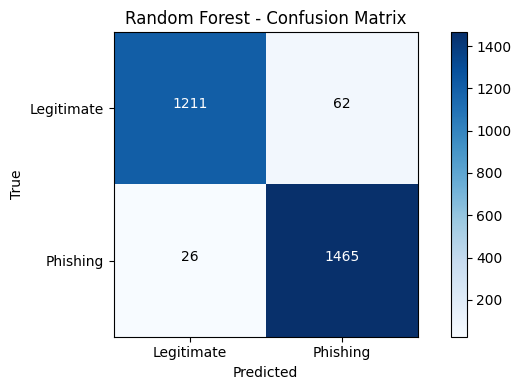

In [108]:
# Predict on the test set 
y_pred_rf = model.predict(X_test)  

# Generate classification report 
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Legitimate', 'Phishing']))

# Compute confusion matrix 
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plotting the confusion matrix 
plt.figure(figsize=(7, 4))
plt.imshow(conf_matrix_rf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Random Forest - Confusion Matrix')
plt.colorbar()
classes = ['Legitimate', 'Phishing']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Adding labels
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, conf_matrix_rf[i, j], horizontalalignment='center',
                 color='white' if conf_matrix_rf[i, j] > conf_matrix_rf.max() / 2. else 'black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Results

With the random forest model the accuracy is greatly improved over the simple decision tree but at the cost of interpretability.

## 6. Deployment

### 6.1 Decision tree classifier

#### Instructions for Internet Analyst

To determine whether a website is likely to be a phishing site, follow these steps based on the decision tree:

**1. Check the SSL Certificate (`sslfinal_state`)**

- **If the SSL certificate is valid (uses HTTPS, issuer is trusted, and the certificate is 1 year or older):**
  - **Decision**: The website is likely legitimate.

- **Else (if the SSL certificate is not valid):**
  - **Check the URL of Anchor (`url_of_anchor`):**
    - **If the percentage of suspicious URL elements is less than 31%:**
      - **Decision**: The website is likely legitimate.
    - **Else (if the percentage of suspicious URL elements is 31% or higher):**
      - **Check the Links in Tags (`links_in_tags`):**
        - **If the percentage of links in `<meta>`, `<script>`, and `<link>` tags is less than 17%:**
          - **Decision**: The website is likely legitimate.
        - **Else (if the percentage of links in these tags is 17% or higher):**
          - **Decision**: The website is likely a phishing site.

- **Else (if none of the above conditions apply):**
  - **Check the Prefix/Suffix in the Domain (`prefix_suffix`):**
    - **If the domain name does not include a `-` symbol:**
      - **Decision**: The website is likely legitimate.
    - **Else (if the domain name includes a `-` symbol):**
      - **Check the Web Traffic (`web_traffic`):**
        - **If the website rank is higher than 100,000:**
          - **Decision**: The website is likely a phishing site.
        - **Else (if the website rank is lower than 100 000):**
          - **Decision**: The website is likely legitimate.

#### Summary

By following these steps, you can manually determine whether a website is likely to be a phishing site or not. 

### 6.2 Random forest classifier

The random forest classifier would be suitable for integrating into a web application to detect phishing sites dynamically.